## Imports/Setup

In [1]:
%run ../00_functions/00_custom_functions.ipynb
standard_setup(extra_packages=True, verbose=False)
data_ingestion_prep(start_yearmonth='1979-01', end_yearmonth='2022-12', verbose=False)

env: ESMFMKFILE=/home/ds4114/.conda/envs/leap_test202308-3/lib/esmf.mk
Files will be outputed as: .nc
ECMWF CDS API key already installed


In [2]:
import cmocean as cm 

## Set Input Files

In [3]:
#load post-ML file from 04 script with model and learned corrections
xr_full_mod_output = xr_open_dataset_custom(global_vars['reconstruction_folder'] + 'HPD_LEAP_fco2-error-reconstructed-8-GOBMs_198201-202212.nc')
gobms_processed = xr_open_dataset_custom(global_vars['download_folder'] + 'GOBM/processed/GOBM_GCB-2023_fco2-8-models_195901-202212.nc')

coast_unscaled = xr_open_dataset_custom(global_vars['download_folder'] +'pCO2/processed/fCO2_NOAA-NCEI_MPI-ULB-SOM-FFN_195901-202212.nc')

In [35]:
#the required flux variables are a bit different from the residual method but similar (should we merge?)
if False: #using the current version of things
    #flux vars
    k_ds= xr.open_dataset(global_vars['download_folder'] + 'SeaFlux/processed/HPD-Flux-Prep_LDEO_ERA5-K0-kw-atmos_pco2_195901-202212.nc')
    
    #area file - using seaflux product rather than FluxKit but lmk if we should change
    seaflux = xr.open_dataset(global_vars['download_folder'] + 'SeaFlux/originals/SeaFlux_LDEO_SeaFlux-v202301-all_1982-2022.nc')
    seaflux = seaflux.rename({'lat':'ylat','lon':'xlon'})
    
    #for a land ocean mask, we can use the one we created in data processing for consistency rather than the one in the prior code
    land_mask = xr.open_dataset(global_vars['download_folder'] + 'Masks/processed/mask_LEAP_land-sea-network.nc')

else: #previous version
    k_ds = xr.open_dataset("/data/artemis/workspace/afay/LDEO_HPD/data_for_flux/ERA5_K0_kw_atmos_pco2_1959-2022.nc") #created by prep_gas_transfer.ipynb
    k_ds = k_ds.rename({'lat':'ylat','lon':'xlon'})
    fk = xr.open_dataset('/data/artemis/observations/SOCOM/extra_files/FluxKit_calculation_1982-2019_v20201120.nc') #just used to get area file. dont need to update
    land_mask = xr.open_dataset('/data/artemis/observations/SOCOM/extra_files/RECCAP2_region_masks_all.nc') 
    land_mask = land_mask.rename({'seamask':'net_mask', 'lat':'ylat','lon':'xlon'})

In [8]:
#more variables
gobm_list = ['CNRM-ESM2-1', 'FESOM2-REcoM', 'IPSL', 'MOM6-Princeton', 'MRI-ESM2-2','NorESM-OC1.2', 'CESM-ETHZ', 'ACCESS']
climatology_time_start, climatology_time_end = '2000-01' , '2022-12'   
back_in_time_start, back_in_time_end         = '1959-01' , '1981-12'
normal_hpd_start, normal_hpd_end             = '1982-01' , '2022-12'  #there may be a better way than listing all these periods but added for clarity/debugging when filtering and reshaping data

back_in_time_numb_of_years = (int(back_in_time_end[0:4])+1) - int(back_in_time_start[0:4]) #no changes needed

## Climatology of Corrections

In [9]:
#group by to get 12 month average
tmp = xr_full_mod_output.get([x+'_error_correction' for x in gobm_list])
tmp_clim = tmp.sel(time=slice(str(climatology_time_start),str(climatology_time_end))).groupby("time.month").mean("time")
clim_corrections = tmp_clim.to_array(dim = 'model_correction') #to reshape so models are together

In [10]:
#duplicate climatology for time range we care about for ease of joining
clim_corrections_tiled = xr.broadcast( clim_corrections, xr.DataArray(np.ones([back_in_time_numb_of_years]), dims=("year")))[0]
clim_corrections_tiled = clim_corrections_tiled.stack(time=['year','month'])
clim_corrections_tiled = clim_corrections_tiled.transpose('model_correction','time','ylat','xlon')

In [11]:
#filter gobm original data and add climatology for back in time period
gobms_stacked = gobms_processed.get(gobm_list).sel(time=slice(str(back_in_time_start),str(back_in_time_end))).to_array(dim = 'gobm')
gobms_back_in_time = gobms_stacked + clim_corrections_tiled.data
#gobms_back_in_time = gobms_back_in_time.rename({'gobm':'gobm_updated'})

In [12]:
#for the more recent period, we just add the gobm value to the ML derived correction
tmp_xr_models = xr_full_mod_output.get(gobm_list).sel(time=slice(str(normal_hpd_start),str(normal_hpd_end))).to_array(dim = 'gobm')
tmp_xr_model_corrs = xr_full_mod_output.get([x+'_error_correction' for x in gobm_list]).sel(time=slice(str(normal_hpd_start),str(normal_hpd_end))).to_array(dim = 'model_corr')
gobms_normal_hpd = tmp_xr_models + tmp_xr_model_corrs.data
#gobms_normal_hpd = gobms_normal_hpd.rename({'model':'gobm_updated'})

In [13]:
#the full set is the back in time with the normal hpd
gobms_combined = xr.combine_by_coords( [gobms_back_in_time.to_dataset(name='hpd_fco2'), gobms_normal_hpd.to_dataset(name='hpd_fco2')] )
gobms_combined

<xarray.Dataset>
Dimensions:   (ylat: 180, xlon: 360, time: 768, gobm: 8)
Coordinates:
  * ylat      (ylat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * xlon      (xlon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time      (time) datetime64[ns] 1959-01-15 1959-02-15 ... 2022-12-15
  * gobm      (gobm) object 'CNRM-ESM2-1' 'FESOM2-REcoM' ... 'ACCESS'
Data variables:
    hpd_fco2  (gobm, time, ylat, xlon) float64 nan nan nan nan ... nan nan nan

In [15]:
#ouptut if desired
gobms_combined['hpd_fco2'].attrs['description'] = "HPD back in time using Climatology of correction (2000-2022) for fCO2 prior to 1982; GOBM with learned correction for 1982+"
gobms_combined['hpd_fco2'].attrs['units'] = "uatm"
gobms_combined.attrs['title']="LDEO-HPD Clim Correct 2000-2022"
gobms_combined.attrs['notes']="no filling for missing regions done"
gobms_combined.attrs['history']="XGBoost results and Clim Corrections by ds4114"
gobms_combined.attrs['institution']="Lamont Doherty Earth Observatory at Columbia"
#gobms_combined.attrs['references']="/home/afay/LDEO_HPD/Back_in_Time/recon_pCO2_CO2flux_v2023.ipynb"  #to be updated
gobms_combined.attrs['date_created']=str(datetime.datetime.now())

if False:
    output_xarray_with_date(gobms_combined, output_folder+'', 'HPD_LEAP_fco2-8-GOBMs-with-climatology2000', filetype=output_file_type)

#### Coastal Filling

In [16]:
recon = gobms_combined['hpd_fco2'].mean("gobm")  #note this was the version used, not np.nanmean(gobms_combined['hpd_fco2'],axis=0), though they both result in same number of nulls

weights = np.cos(np.deg2rad(recon.ylat)) #global area weighted version
weights.name = "weights"
scaling_weighted = (recon/coast_unscaled.fco2).weighted(weights).mean(['xlon','ylat']) 
#scaling_weighted.plot()
coast_scaled = coast_unscaled.fco2*scaling_weighted

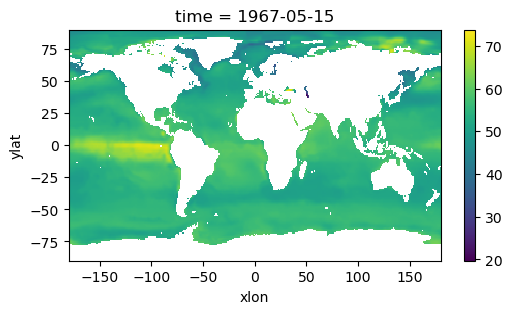

In [19]:
#just to confirm that it's looking right. 
#if you do a month like #100 then it should be mostly positive and then if you do a month like #650, it should be mostly negative
if True:
    fig = plt.figure(figsize=(figsizew,figsizeh))
    (coast_unscaled.fco2[100,:,:] - coast_scaled[100,:,:]).plot();
    #(coast_unscaled.fco2[650,:,:] - coast_scaled[650,:,:]).plot();
#output to netcdf too if desired

## Flux
##### Load Atmospheric Conditions

In [25]:
kw = k_ds.kw * (24/100)  #cm/hr --> m/day
K0 = k_ds.K0/1000 # mmol / m3 / atm  --> mol/m3/uatm
mC = 12.0108 # g / mol
pCO2air = k_ds.atmos_fco2 # micro atmospheres, this is global atmos fco2 from esrl (using MLoa to extend back in time.
icef = k_ds.ice

In [26]:
hpd = gobms_combined['hpd_fco2'].mean("gobm").fillna(coast_scaled)

co2 = kw * K0 * (hpd - pCO2air) * (1-icef) * mC * 365 # g / m2 / year

In [39]:
flux_region = (co2.where(land_mask['net_mask']>=1)*(seaflux.area)).sum(['ylat','xlon'])
flux_hpd = flux_region.groupby("time.year").mean("time")

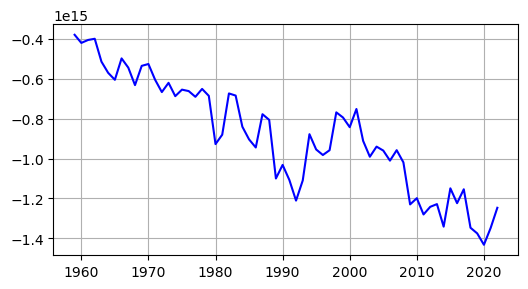

In [40]:
# Plot this up 
fig = plt.figure(figsize=(figsizew,figsizeh))
plt.plot(range(1959,2023),flux_hpd,'blue')
plt.grid(True)

#too different from prior version... #scale is too low, big uptick at the end looks, and some dip in 1998
#might have a bug somewhere -even using old flux variables, scale still seems off but reconstructed mean pco2 looks right?

In [ ]:
#write to file
#tbd